In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3 
!pip install torch

!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.9 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 11.3 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595732 sha256=270ee06753bc51b111f738cd145f0d760a5801dc8bb4fc142fb064e2bfc901e1
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 26.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.p

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [3]:
##GPU 사용 시
device = torch.device("cuda:0")

bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [7]:
import pandas as pd
df = pd.read_csv('df_all.csv')
df = df.iloc[:,[3, 1]]
df

,convrs,cluster
0,그러니까 우리도 정말 신경 많이 써야 될 것 같아 제가 그거 요즘 하잖아요또 동산을...,0
1,그렇게 매일 비가 오나 눈이 오나 강둑을 걷는 사람들 있잖아내가 만약 수영장 끊어서...,0
2,운동선수들도 보면 슬럼프도 있고 잘 나갈 때도 있고 그게 다 있잖아요나도 그러니까 ...,0
3,그런데 내가 그동안 말은 안 했지만 당신을 내가 너무 잘 안다는 게 문자라니까 당신...,0
4,우리나라 사람들 보면 그렇게 하는 사람들이 많거든물론 보편화 되고 대중화됐지지금도 ...,0
...,...,...
112,나는 골프를 못 치니까 좀 그런데 너도 직접 하는 것보다 구경하는 편이잖아나도 헬스...,13
113,나는 하루에 한 번 씩 이렇게 잡아주면 실력이 엄청 늘을 것 같은디도 우리랑 못 치...,13
114,나도 본 지 얼마 안됐거든 유튜브를 너무 진짜 시간도 잘 가고 건강에도 좋고 너무 ...,13
115,돈 안 들고 신체적으로 별로 무리가 안 되니까 그게 가장 좋은 방법이지그것도 나가든...,13


In [8]:
df.isnull().sum()

convrs     0
cluster    0
dtype: int64

In [11]:
np.unique(df.cluster)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [10]:
df.loc[(df['cluster']== 13), 'cluster'] = 3
df.loc[(df['cluster']== 12), 'cluster'] = 10

In [12]:
np.unique(df.cluster)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['convrs'], df['cluster'], stratify=df['cluster'], random_state=0)

In [14]:
train = []
for q, label in zip(x_train, y_train)  :
    data = []
    data.append(q)
    data.append(str(label))

    train.append(data)

In [15]:
test = []
for q, label in zip(x_test, y_test)  :
    data = []
    data.append(q)
    data.append(str(label))

    test.append(data)

In [16]:
train[0]

['그러기 때문에 근무하면서 좀 운동을 해 나는 너랑 운동을 같이 하고 싶어그러니까 참 즐기면서 운동을 다니는 게 몸 건강관리에는 제일인 것 같아 차라리 당구를 한번 씩 그냥 재미 삼아 쳐도 몸 전체적으로 운동이 되거든 앞으로는 우리가 전국에 있는 산을 확보할 수 있는 계획을 한번 짜보자 니가 아까 서창에서 자전거를 대여해서 그곳에서 운동한다고 그랬잖아그러면 나하고 한번 시간 내서 자전거를 대여를 해가지고 남평까지 갔다 오자 나가서 운동을 하고 돌아오라고 해꼭 한시간을 하고 와야 된다니까왜냐하면 니가 혈당을 재야 되기 때문에 그 운동을 해야 혈당이 떨어지거든그래서 지금은 스스로 운동을 꾸준히 해야 된다는 게 습관 되어 버렸어 그냥 지금은 한 밤중에 한시간이고 두 시간이고 이제 몸도 허약한데 옆에 친구까지 있으면 이게 건강을 해치게 되는 것 같아 항상 그 사진을 보면 진짜 축구를 하는 사람들은 몸에도 엄청 좋은 것 같아 탁구도 그냥 전신 운동을 한다고 생각하면 가벼운 운동이 돼서 좋을 것 같아',
 '1']

In [17]:
test[0]

['시설을 다 해놓은 것을 보면 생각 없이 해놨다고 잘못됐다고 하더라또 거기서 좀 적다 싶으면 한바퀴 더 돌아주고 강도를 조절해야 되는 거야몸매가 좋아지던데 우리는 하니까 근육도 제대로 발달 안 되는 거 같고 몸이 좋은 것을 느낀다니까 운동을 오래 하면 그렇게 되더라고 하다가 무슨 일이 있어서 그만두거나 하면 게으른 사람은 운동 못 해그래 네 말이 백번 맞다 맞기는 맞는데 나는 싫증이 나면 잘 못 해 다섯바퀴 밖에 못 돌고 같이 가는 사람은 여덟바퀴를 돌거든너 같이 시간 맞추고 얽매이는 거 싫어하는 사람은 수영하기 힘들지 키도 크고 덩치가 있는 있는데도 혈압약도 안 먹는 사람 많고 그렇잖아나는 삼십 대부터 여러 스포츠를 시작해서 계속해왔는데 하여간 그냥 있는 것보다는 뭐라도 해야 해 골프를 치든 수영을 하든 걔가 젊었을 때부터 삼십 대부터 자기한테 맞는 운동을 찾아갔잖아그래 네 말이 전부 맞는 말이다 내가 운동 꾸준하게 해야 된다는 것 나도 내 머리에 항상 그 생각이 있으면서도 실천을 못 하고 있는 것 있지네 말대로 그렇게 해야 내 건강을 챙길텐데 실천을 하기가 어려워',
 '10']

In [18]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [31]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [20]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [21]:
# pytorch용 DataLoader 사용
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 11, 
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)
      

In [23]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [24]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [25]:
# 옵티마이저 선언
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # softmax용 Loss Function 정하기 <- binary classification도 해당 loss function 사용 가능

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


In [26]:
# 학습 평가 지표인 accuracy 계산 
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [32]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [33]:
# 모델 학습 시작
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) # gradient clipping
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
  
    model.eval() # 평가 모드로 변경
    
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.154646873474121 train acc 0.34375
epoch 1 train acc 0.32404891304347827


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 1 test acc 0.26666666666666666


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 2.1917786598205566 train acc 0.28125
epoch 2 train acc 0.33627717391304346


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 2 test acc 0.3


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 2.129209041595459 train acc 0.390625
epoch 3 train acc 0.41270380434782605


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 3 test acc 0.36666666666666664


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 2.0476138591766357 train acc 0.40625
epoch 4 train acc 0.4639945652173913


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 4 test acc 0.36666666666666664


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 2.002082109451294 train acc 0.46875
epoch 5 train acc 0.5169836956521738


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 5 test acc 0.36666666666666664


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 1.9093729257583618 train acc 0.53125
epoch 6 train acc 0.5917119565217391


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 6 test acc 0.4


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 1.9041205644607544 train acc 0.53125
epoch 7 train acc 0.6786684782608696


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 7 test acc 0.36666666666666664


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 1.895703673362732 train acc 0.546875
epoch 8 train acc 0.7082201086956521


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 8 test acc 0.36666666666666664


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 1.8706427812576294 train acc 0.484375
epoch 9 train acc 0.6117527173913043


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 9 test acc 0.36666666666666664


  0%|          | 0/2 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 1.837249994277954 train acc 0.546875
epoch 10 train acc 0.6430027173913043


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 10 test acc 0.36666666666666664


In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
confusion_matrix(y_trues, y_predictions)

array([[121,  89,   3],
       [ 35, 439,  11],
       [ 17, 198, 113]])

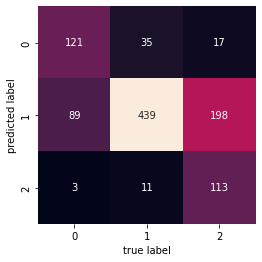

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(y_trues, y_predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
precision = precision_score(y_trues, y_predictions, average = 'weighted')
precision

0.7154880586354921

In [ ]:
recall = recall_score(y_trues, y_predictions, average = 'weighted')
recall

0.6559454191033138

In [ ]:
f1score = f1_score(y_trues, y_predictions, average= 'weighted')
f1score

0.631669155759031